# THE TRAINING DATA 

In [1]:
import random

In [2]:
file=open("train.ft.txt","r",encoding="utf8")
train_file_lines=[x for x in file]
file.close()

In [3]:
random.sample(train_file_lines,10)

["__label__1 Big disappointment...: I ordered this, because like everyone else, I loved this show as a kid, and wanted to share it with my son. When I got the set, it was in 1 box, with 4 places for discs, and each disc had the proper picture on it, as far as I could tell. I had read other people's reviews, and read that they had issues with their discs, so I checked mine. I was disappointed to see that only 1 of my discs worked. I read a reply from the company that the way that they burned the discs might not work for everyone's machine- This should be in the product discription, first of all. Second, why burn a set this way, if they won't work for everyone, and why did one disc work, and the other 3 didn't? Doesn't make a bit of sense to me. I tried them in several different systems, and they didn't work in any of them...just something to be aware of, for others who want to try give it a try!I had no issues returning the disc for a refund, which was great.\n",
 "__label__1 Too Squish

# PRE-PROCESSING

IMPORTING LIBRARIES AND DOWNLOADING TOOLKITS

In [4]:
import lxml
import spacy
import nltk
import re
from bs4 import BeautifulSoup          #To remove html tags while preprocessing reviews.

nltk.download("wordnet")
nltk.download("stopwords")
nltk.download('words')

from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

from spacy.cli.download import download
download(model="en_core_web_sm")

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


FUNCTIONS FOR SCREENING STOPWORDS, NON-ENGLISH WORDS AND LEMMATIZING AND FILTERING WORDS WITH LENGTH LESS THAN 3.

In [5]:
def remove_underscores(sentence):                    #removing unnecessary character occurences
    sentence= sentence.replace("_"," ")
    sentence = sentence.replace("\\","")
    return sentence


def remove_extra_words(sentence):                     #removing stop words and meaningless words and occurences
    new_sentence=""
    for w in sentence.split():
        w=w.lower()
        if w in english_words and w not in stop_words and w.isalpha():
            new_sentence=new_sentence+" "+w
    return new_sentence

def lemmatize_and_filter(sentence, min_word_length): #lemmatizing words and lose the ones with length less than equal to min_word_length.
    sent = ""
    for word in sentence.split():
        word=word.lower()
        if len(lemmatizer.lemmatize(word)) > min_word_length:
            sent= sent+" "+lemmatizer.lemmatize(word)
    return(sent)

FUNCTION FOR POSTAG SCREENING

In [6]:

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# Run in terminal: python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def postags_screening(texts):
    allowed_postags=['ADJ', 'ADV']
    texts_out = []
    for sent in texts:
        doc=nlp(sent)
        sent=""
        for token in doc:
            if token.lemma_ not in ['-PRON-'] and token.pos_ in allowed_postags:        #lemmatization: keeping only adjectives and adverbs
                sent=sent+" "+str(token.lemma_)
        texts_out.append(sent)
    return texts_out


Now we define two functions:
1. split_label_review
2. preprocessed_data

1.split_label_review: This will help convert the unstructured data to a structured dataset by spliting the label/class from the reviews.
2.preprocessed_data:  This will preprocess the reviews with all the functions defined above.

In [7]:
#re.sub(r'[^\w\s],"",string) to remove punctuations.
#re.sub(r'^https?:\/\/.*[\r\n]*', '', string) to remove urls.
#re.split("__label__[1|2]",string)[1] to get the 2nd element of the split, i.e, the review
#strip() to remove whitespaces
#re.findall("1|2", str(lines))[0] to store the first number encountered in the line of the review as the label of the review.
#BeautifulSoup(string, "lxml").text) to remove html tags


def split_label_review(data):
    #takes in list of raw data and returns list of string sentences and the list of their corresponding labels.
    labels = [int(re.findall("1|2", str(lines))[0]) for lines in data]
    reviews = [re.split("__label__[1|2]",str(lines))[1].strip().lower() for lines in data]
    return(reviews,labels)


def preprocessed_data(data):        #takes in list of raw data and returns list of processed string sentences and the list of their corresponding labels.
    reviews = [remove_extra_words(lemmatize_and_filter(BeautifulSoup(re.sub(r'[^\w\s]|^https?:\/\/.*[\r\n]*|\d+', '', remove_underscores(str(lines)).strip().lower()), "lxml").text,3)) for lines in data]
    reviews = postags_screening(reviews)
    return(reviews)



-------------------------------------------------------------------------------------------------------------------------------

# DATA TRANSFORMATION

This will convert the preprocessed reviews to **term frequency-inverse document frequency** matrix. 

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
def to_arrays(data):
    vectorizer = TfidfVectorizer(smooth_idf=True)
    tf_idf = vectorizer.fit_transform(data)
    tf_idf = tf_idf.toarray()
    return tf_idf

# DATA REDUCTION

In [9]:
#PCA
from sklearn.decomposition import PCA
def data_reduction(array,n_components):
    pca = PCA(n_components=n_components)
    array = pca.fit_transform(array)
    return array

#  Train-Test-Split

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_data = random.sample(train_file_lines,10000)
train_data,labels = split_label_review(train_data)
train_data = preprocessed_data(train_data)
train_data,labels


([' second good many good technical fast well melodic acoustic never long almost great dark exciting epic much good amazing entertaining ever heavy musically advanced even',
  ' nice compact straight',
  ' mainly heroic',
  ' bitter ramble intense',
  ' simply similar certain second small evil beautiful genuine crazy last last terrible well electric incredible original',
  ' wrong childish ordinary individual worth innocent',
  ' difficult much',
  ' logical clean civil mostly nuclear great totally nearly adjective even bad absolutely nonsensical also actual black worth rental',
  ' automatically somewhat frequently least middle somewhat big disappointed long even light past long',
  ' quiet solid quiet even high first huge enough easy front somewhat flimsy',
  ' many disappointed personal unique complex interesting many historical many political unique',
  ' bodyguard glad still much twice',
  ' good sure especially',
  ' great soon poor dark terrible amateur good annoying awful great

**WITHOUT DATA REDUCTION**: X_train, X_test, y_train, y_test

In [12]:
X = to_arrays(train_data)
X.shape

(10000, 5013)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
        X, labels, test_size=0.33, random_state=42)

**WITH DATA REDUCTION**: X_train_red, X_test_red, y_train_red, y_test_red

In [14]:
X_red = data_reduction(X,500)
X_red.shape

(10000, 500)

In [15]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
        X_red, labels, test_size=0.33, random_state=42)

# MODELING

Now we are going to train three classifiers on our data:
1. Random Forest Classifier
2. Logistic Regression
3. Support Vector Machine

In [16]:
import numpy as np
from sklearn import metrics  
import matplotlib.pyplot as plt
%matplotlib inline

### **1. RANDOM FOREST CLASSIFIER**

In [17]:
from sklearn.ensemble import RandomForestClassifier

def model_(X_train, X_test, y_train, y_test,n_estimators):
    
    Y=[]
    
    for n in n_estimators:
        # creating a RF classifier
        clf = RandomForestClassifier(n_estimators = n,criterion="entropy", random_state=45)  

        # Training the model on the training dataset
        # fit function is used to train the model using the training sets as parameters
        clf.fit(X_train,y_train)
        y_pred = clf.predict(X_test)
        Y.append(metrics.accuracy_score(y_test, y_pred))

    plt.plot()
    plt.plot(n_estimators,Y)
    plt.title("RANDOM FOREST CLASSIFIER",fontweight="bold")
    plt.xlabel("Number of trees")
    plt.ylabel("Accuracy")
    plt.show()


**IMPLEMENTATION**

In [18]:
n_estimators=np.arange(100,1000,100)
n_estimators

array([100, 200, 300, 400, 500, 600, 700, 800, 900])

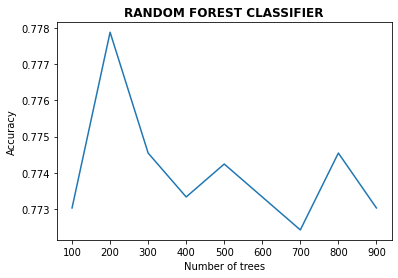

In [19]:
#without PCA
model_(X_train, X_test, y_train, y_test,n_estimators=n_estimators)

**CONCLUSION**: The model trains with the highest accuracy when the number of decision trees are approximately 110.

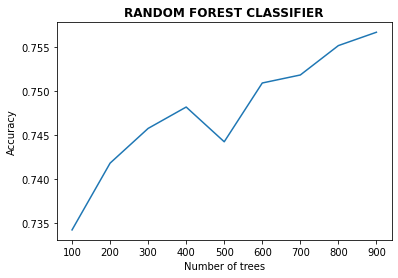

In [20]:
#with PCA
model_(X_train_red, X_test_red, y_train_red, y_test_red,n_estimators=n_estimators)

**CONCLUSION**: The number of estimators versus accuracy graph smoothens as we start considering the feautures(here words) according to their significance but takes a large number of estimators to reach the highest accuracy of the previous model.

### **2. LOGISTIC REGRESSION**

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix

def model2_(X_train,X_test,y_train,y_test,title):
    lr = LogisticRegression(random_state=30)
    lr.fit(X_train,y_train)
    y_pred = lr.predict(X_test)
    print("MODEL ACCURACY = ",metrics.accuracy_score(y_test, y_pred))


    np.set_printoptions(precision=2)
    
    cmp = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 
           'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r',
           'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r',
           'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
           'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r',
           'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r',
           'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r',
           'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r',
           'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r',
           'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 
           'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 
           'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet',
           'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma',
           'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer','summer_r', 
           'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r',
           'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']
    
    disp = plot_confusion_matrix(lr, X_test, y_test,
                                 display_labels=set(y_train+y_test),
                                 cmap=random.sample(cmp,1)[0])
                                 
    disp.ax_.set_title(title)
    """
    print(title)
    print(disp.confusion_matrix)
    """
    plt.show()


**IMPLEMENTATION**

**WITHOUT DATA REDUCTION**

MODEL ACCURACY =  0.7830303030303031


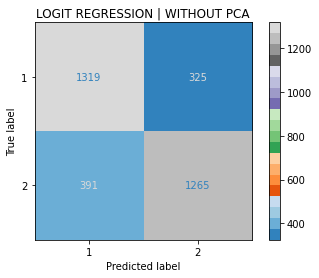

In [67]:
model2_(X_train,X_test,y_train,y_test,"LOGIT REGRESSION | WITHOUT PCA")

**WITH DATA REDUCTION**

MODEL ACCURACY =  0.7806060606060606


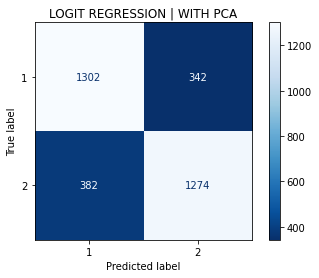

In [68]:
model2_(X_train_red, X_test_red, y_train_red, y_test_red,"LOGIT REGRESSION | WITH PCA")

### **3. SVM**

In [69]:
from sklearn import svm
def model3(X_train,X_test,y_train,y_test,title):
    clf = svm.SVC()
    clf.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print("MODEL ACCURACY = ",metrics.accuracy_score(y_test, y_pred))


    np.set_printoptions(precision=2)
    
    cmp = ['Accent', 'Accent_r', 'Blues', 'Blues_r', 'BrBG', 'BrBG_r', 'BuGn', 'BuGn_r', 'BuPu', 'BuPu_r', 'CMRmap', 
           'CMRmap_r', 'Dark2', 'Dark2_r', 'GnBu', 'GnBu_r', 'Greens', 'Greens_r', 'Greys', 'Greys_r', 'OrRd', 'OrRd_r',
           'Oranges', 'Oranges_r', 'PRGn', 'PRGn_r', 'Paired', 'Paired_r', 'Pastel1', 'Pastel1_r', 'Pastel2', 'Pastel2_r',
           'PiYG', 'PiYG_r', 'PuBu', 'PuBuGn', 'PuBuGn_r', 'PuBu_r', 'PuOr', 'PuOr_r', 'PuRd', 'PuRd_r', 'Purples', 
           'Purples_r', 'RdBu', 'RdBu_r', 'RdGy', 'RdGy_r', 'RdPu', 'RdPu_r', 'RdYlBu', 'RdYlBu_r', 'RdYlGn', 'RdYlGn_r',
           'Reds', 'Reds_r', 'Set1', 'Set1_r', 'Set2', 'Set2_r', 'Set3', 'Set3_r', 'Spectral', 'Spectral_r',
           'Wistia', 'Wistia_r', 'YlGn', 'YlGnBu', 'YlGnBu_r', 'YlGn_r', 'YlOrBr', 'YlOrBr_r', 'YlOrRd', 'YlOrRd_r',
           'afmhot', 'afmhot_r', 'autumn', 'autumn_r', 'binary', 'binary_r', 'bone', 'bone_r', 'brg', 'brg_r', 'bwr', 'bwr_r',
           'cividis', 'cividis_r', 'cool', 'cool_r', 'coolwarm', 'coolwarm_r', 'copper', 'copper_r', 'cubehelix', 'cubehelix_r',
           'flag', 'flag_r', 'gist_earth', 'gist_earth_r', 'gist_gray', 'gist_gray_r', 'gist_heat', 'gist_heat_r', 'gist_ncar', 
           'gist_ncar_r', 'gist_rainbow', 'gist_rainbow_r', 'gist_stern', 'gist_stern_r', 'gist_yarg', 'gist_yarg_r', 'gnuplot', 
           'gnuplot2', 'gnuplot2_r', 'gnuplot_r', 'gray', 'gray_r', 'hot', 'hot_r', 'hsv', 'hsv_r', 'inferno', 'inferno_r', 'jet',
           'jet_r', 'magma', 'magma_r', 'nipy_spectral', 'nipy_spectral_r', 'ocean', 'ocean_r', 'pink', 'pink_r', 'plasma',
           'plasma_r', 'prism', 'prism_r', 'rainbow', 'rainbow_r', 'seismic', 'seismic_r', 'spring', 'spring_r', 'summer','summer_r', 
           'tab10', 'tab10_r', 'tab20', 'tab20_r', 'tab20b', 'tab20b_r', 'tab20c', 'tab20c_r', 'terrain', 'terrain_r',
           'turbo', 'turbo_r', 'twilight', 'twilight_r', 'twilight_shifted', 'twilight_shifted_r', 'viridis', 'viridis_r', 'winter', 'winter_r']
    
    disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=set(y_train+y_test),
                                 cmap=random.sample(cmp,1)[0])
                                 
    disp.ax_.set_title(title)
    """
    print(title)
    print(disp.confusion_matrix)
    """
    plt.show()

**IMPLEMENTATION**

**WITHOUT DATA REDUCTION**

MODEL ACCURACY =  0.7872727272727272


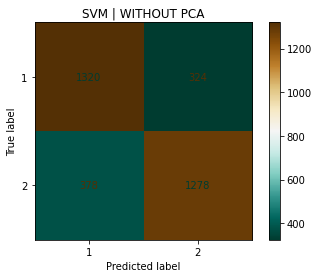

In [70]:
model3(X_train,X_test,y_train,y_test,"SVM | WITHOUT PCA")

**WITH DATA REDUCTION**

MODEL ACCURACY =  0.7775757575757576


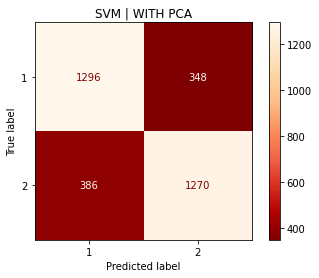

In [71]:
model3(X_train_red, X_test_red, y_train_red, y_test_red,"SVM | WITH PCA")

**CONCLUSION:** Excluding features/words decreases the performance of the model slightly but is more time efficient than the model that is trained without any exclusion.